In [2]:
import pandas as pd
import os
import geopandas as gpd
import geojson
import networkx as nx
import csv
import numpy as np
import os
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from datetime import datetime

In [3]:
disp_data = pd.read_excel(r'/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx')
disp_data_d_f = disp_data[(disp_data['Reason']=='Drought related') | (disp_data['Reason']=='Flood')]
disp_data_drought = disp_data[disp_data['Reason']=='Drought related']

In [4]:
v= disp_data_drought["Month End"]
v=v.values
dt = [datetime.strptime(v[i], "%d/%m/%Y") for i in range(len(v))]
q=[]
for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i])) 
disp_data_drought.insert(loc=3, column='date_timestamp', value=q)
disp_data_drought = disp_data_drought.sort_values("date_timestamp")
disp_data_drought['Month End'] = pd.to_datetime(disp_data_drought['Month End'], dayfirst=True)

aggregated_data = disp_data_drought.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) District', 'Current (Arrival) District'])['Number of Individuals'].sum().to_frame()
dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) District').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) District','Current (Arrival) District'])
disp_data_drought1 = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

disp_matxs = disp_data_drought1.pivot_table(index=['time','Previous (Departure) District'], columns='Current (Arrival) District', values='Number of Individuals', aggfunc='sum')
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

In [5]:
# initialize empty lists to store the degree and self weight arrays
df_national_list = []
df_stats_list = []

# loop over the files in the directory
for f, time in tqdm(enumerate(disp_data_drought1['time'].unique())):
 
    df = disp_data_drought1[disp_data_drought1['time']==time]

    G = nx.from_pandas_edgelist(df, source='Previous (Departure) District', target='Current (Arrival) District', 
                    edge_attr=['Number of Individuals'], create_using=nx.MultiDiGraph())

    nodes = list(nx.nodes(G))
    in_degrees_dict=dict(G.in_degree(weight='Number of Individuals'))
    in_degrees = list(in_degrees_dict.values())
    out_degrees_dict=dict(G.out_degree(weight='Number of Individuals'))
    out_degrees = list(out_degrees_dict.values())
    OD = nx.adjacency_matrix(G, weight='Number of Individuals')
    OD_arr = OD.toarray()
    nan_one=np.empty(1)
    nan_one[:]=np.nan
    self_weight = [np.divide(OD_arr[i, i], np.sum(OD_arr[i]), out=nan_one, where=not(np.isnan(np.sum(OD_arr[i])) or np.sum(OD_arr[i])==0))[0] for i in range(len(OD_arr))]

    # calculate the mean and quantiles of the degree and self weight arrays
    mean_degree = np.nanmean(in_degrees)
    in_degree_quantiles = np.nanquantile(in_degrees, [0.025, 0.5, 0.975])
    out_degree_quantiles = np.nanquantile(out_degrees, [0.025, 0.5, 0.975])

    mean_self_weight = np.nanmean(self_weight)
    self_weight_quantiles = np.nanquantile(self_weight, [0.025, 0.5, 0.975])
    
    # append the degree and self weight arrays and their quantiles to the lists
    date_list=[time]*len(nodes)
    df_national=pd.DataFrame({'date':time, 'mean_degree': mean_degree, 'mean_self_weight': mean_self_weight, 'in_degree_lower': in_degree_quantiles[0], 'in_degree_median': in_degree_quantiles[1], 'in_degree_upper': in_degree_quantiles[2], 'out_degree_lower': out_degree_quantiles[0], 'out_degree_median': out_degree_quantiles[1], 'out_degree_upper': out_degree_quantiles[2], 'self_weight_lower': self_weight_quantiles[0],'self_weight_median': self_weight_quantiles[1],'self_weight_upper': self_weight_quantiles[2]}, index=[0])
    df_national_list.append(df_national)
    df_stats = pd.DataFrame({'date':date_list,'geoid': nodes, 'in_degree': in_degrees, 'out_degree': out_degrees,'self_weight': self_weight})
    df_stats_list.append(df_stats)

0it [00:00, ?it/s]

92it [00:03, 23.97it/s]


In [6]:
df_stats = pd.concat(df_stats_list)
#df_stats['date'] = df_stats['date'].str.replace('_', '-')
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_national = df_stats.groupby('date').agg({'in_degree': 'mean', 'out_degree': 'mean', 'self_weight': 'mean'})
df_national = df_national.reset_index()

## Plot national averages

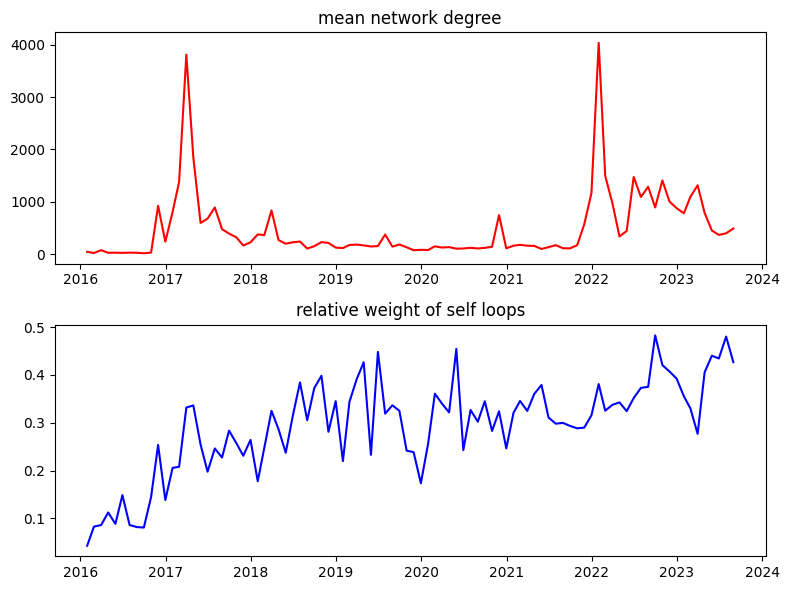

In [7]:
# plot the in degree and self weight arrays for the first file in the directory
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
palette=['r','blue']

dates = df_stats['date'].unique()
ax[0].plot(dates,df_national['in_degree'],color=palette[0])
ax[0].set_title('mean network degree')
ax[1].plot(dates,df_national['self_weight'],color=palette[1])
ax[1].set_title('relative weight of self loops')

fig.tight_layout()

## Plot a subregion

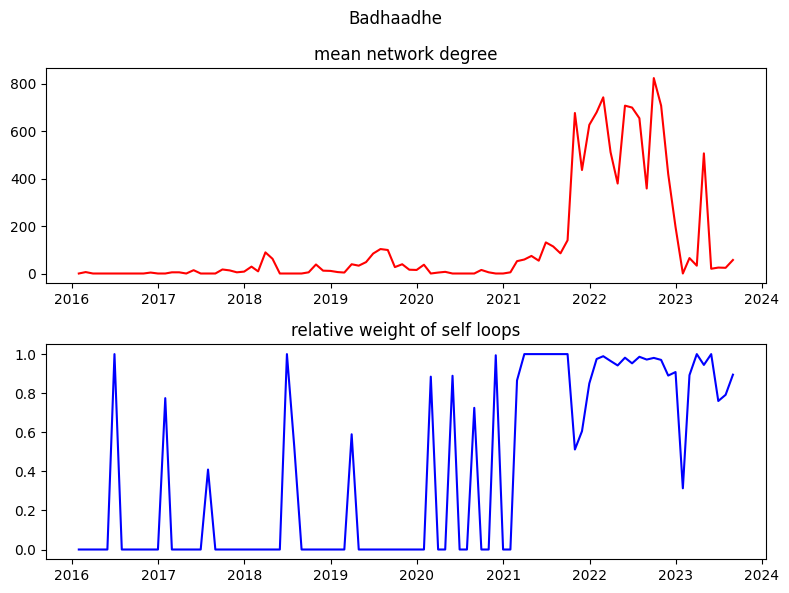

In [7]:
random_county=df_stats['geoid'].sample(44).values[0]
df_stats_county=df_stats[df_stats['geoid']==random_county]
df_stats_county=df_stats_county.sort_values(by='date')

# plot the in degree and self weight arrays for a random county
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(df_stats_county['date'],df_stats_county['out_degree'],color=palette[0])
ax[0].set_title('mean network degree')
ax[1].plot(df_stats_county['date'],df_stats_county['self_weight'],color=palette[1])
ax[1].set_title('relative weight of self loops')
fig.suptitle(random_county)
fig.tight_layout()

## Plot by state

In [8]:
#aggregate by state
cont = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")

In [9]:
reg_state = disp_data_drought[['Previous (Departure) District','Previous (Departure) Region']]
#remove duplicates from reg_state
reg_state = reg_state.drop_duplicates('Previous (Departure) District', keep='first')

In [10]:
df_merged_district = pd.merge(df_stats, reg_state, left_on=['geoid'], right_on=['Previous (Departure) District'], how='left')
df_agg_d = df_merged_district.groupby(['geoid', 'date']).agg({'in_degree': 'mean', 'out_degree': 'mean', 'self_weight': 'mean'})
df_agg_d.reset_index(inplace=True)
df_agg_d['date']=pd.to_datetime(df_agg_d['date'])

In [11]:
df_merged_region = pd.merge(df_stats, reg_state, left_on=['geoid'], right_on=['Previous (Departure) District'], how='left')
df_agg_r = df_merged_region.groupby(['Previous (Departure) Region', 'date']).agg({'in_degree': 'mean', 'out_degree': 'mean', 'self_weight': 'mean'})
df_agg_r.reset_index(inplace=True)
df_agg_r['date']=pd.to_datetime(df_agg_r['date'])

In [12]:
df_agg_r['internal mobility'] = df_agg_r['self_weight']*df_agg_r['out_degree']
df_agg_r['external mobility out'] = df_agg_r['out_degree'] - df_agg_r['internal mobility']
df_agg_r['external mobility in'] = df_agg_r['in_degree'] - df_agg_r['internal mobility']
df_agg_r['external mobility total'] = df_agg_r['external mobility out'] + df_agg_r['external mobility in']

In [13]:
#subset to take only 2022
df_agg_r_2022 = df_agg_r[df_agg_r['date'].dt.year == 2022]

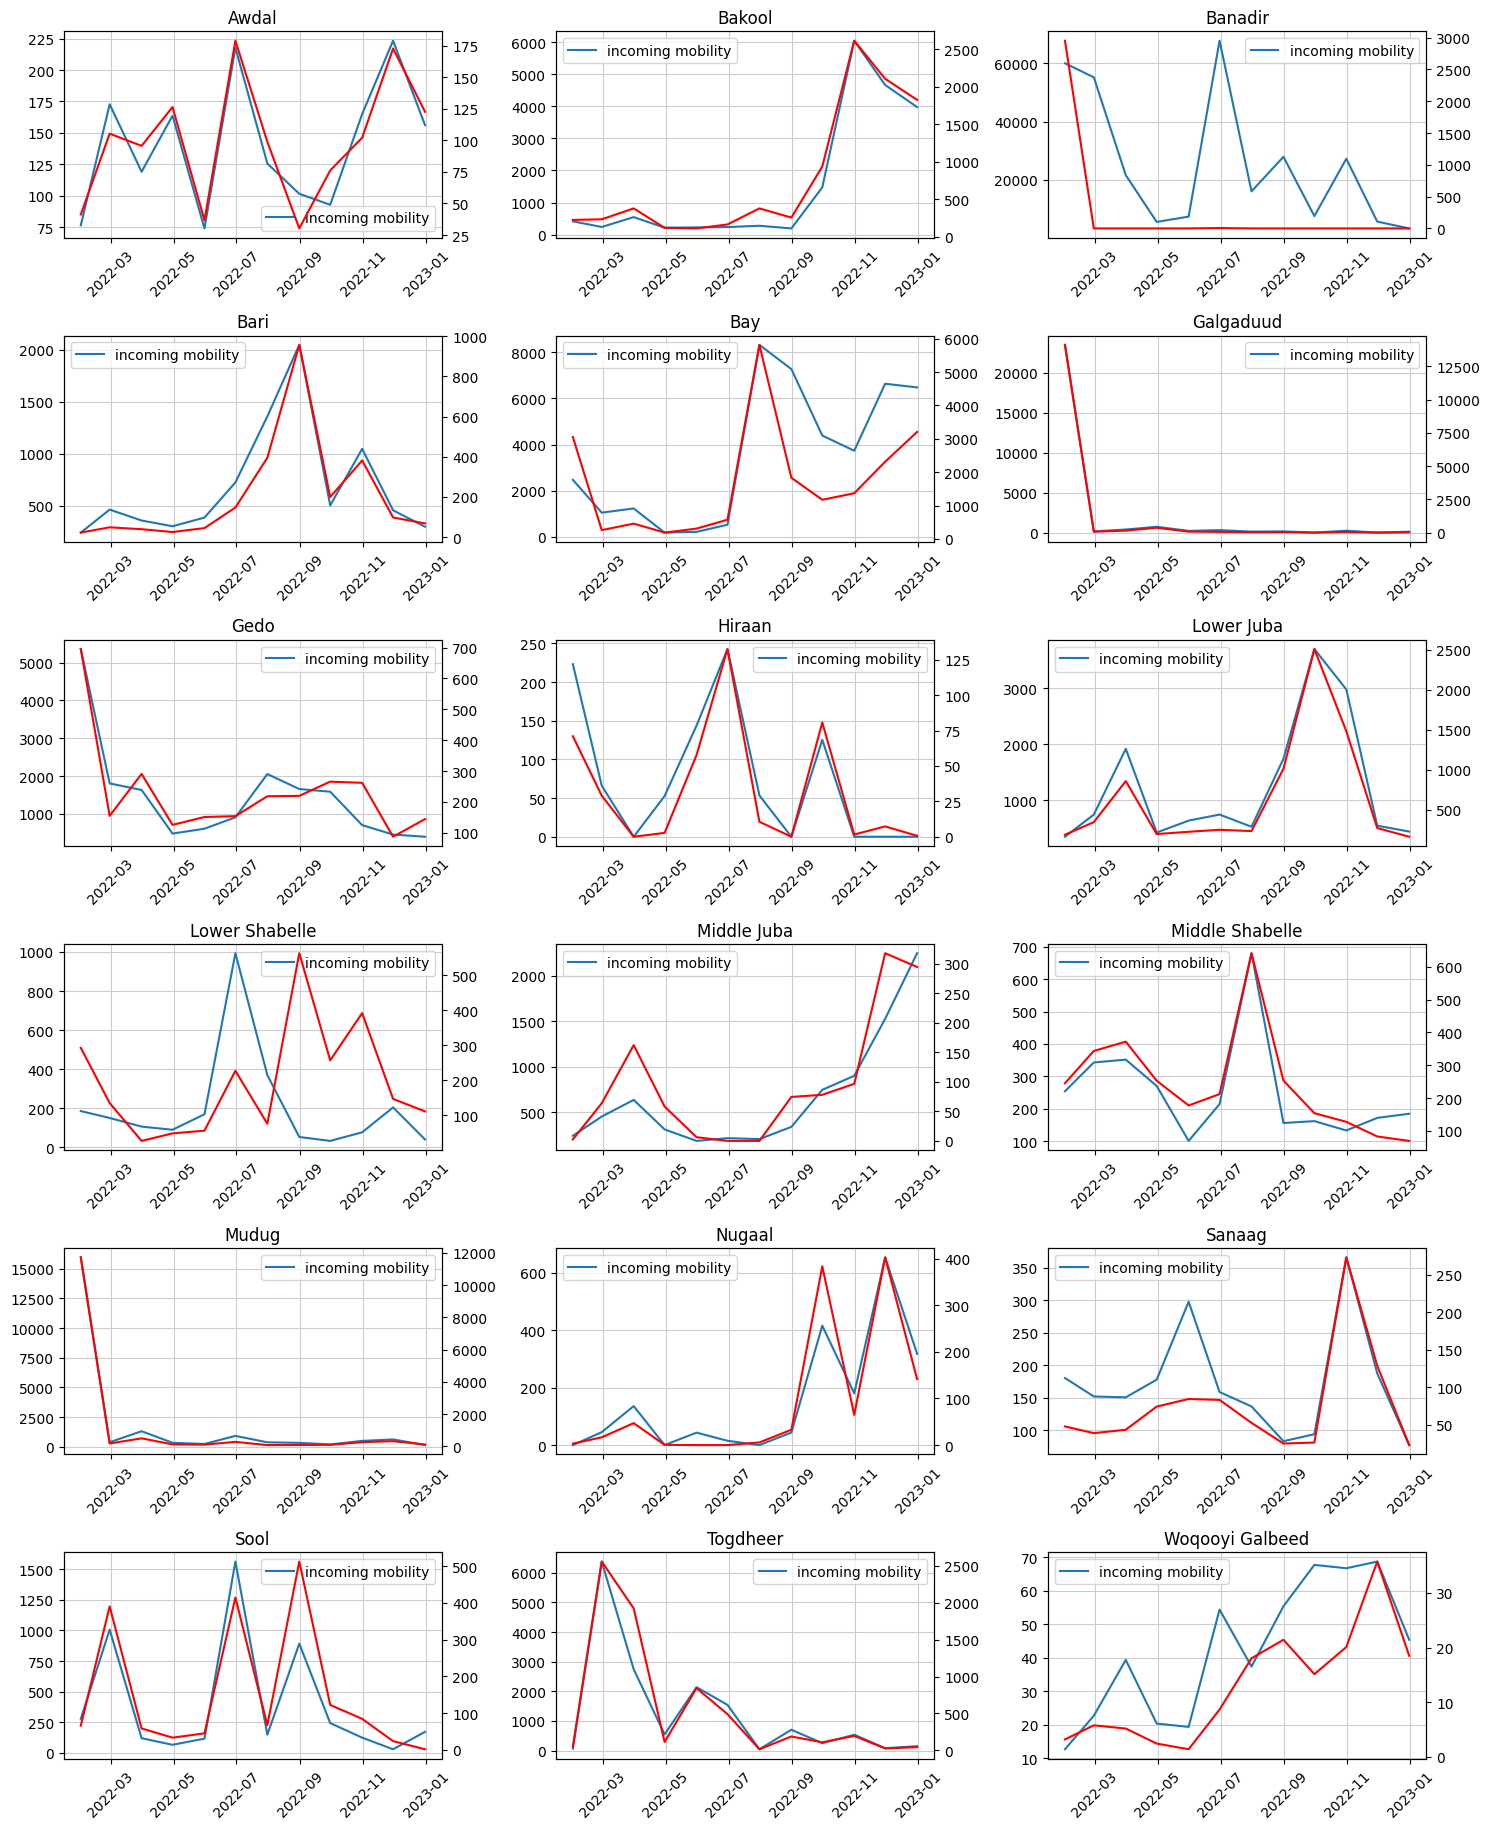

In [18]:
# create a figure with subplots
fig, axes = plt.subplots(6, 3, figsize=(15, 20))
ax = axes.flatten()
states = df_agg_r_2022['Previous (Departure) Region'].unique()
# iterate over the states
for i, state in zip(range(len(states)), states):

    df_agg_state = df_agg_r_2022[df_agg_r_2022['Previous (Departure) Region']==state]
    # plot value of stringency index for each date
    ax[i].plot(df_agg_state['date'], df_agg_state['internal mobility']+df_agg_state['external mobility in'], label='incoming mobility')
    ax[i].plot(df_agg_state['date'], df_agg_state['internal mobility'], label='internal mobility')  
    #ax[i].twinx().plot(df_agg_state['date'], df_agg_state['internal mobility'], label='internal mobility', color='red')

    ax[i].tick_params(axis='x', rotation=45)

    # add a grid
    ax[i].grid(True, color = '0.8', which='major')
    ax[i].grid(True, color = '0.8', alpha = 0.5, which='minor', linestyle='--')

    ax[i].legend()
    # set state name as title
    ax[i].set_title(state)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# start_date=pd.to_datetime('2020-01-01')
# end_date=pd.to_datetime('2021-04-28')
# df_agg1_cut=df_agg1[(df_agg1['date']>=start_date) & (df_agg1['date']<=end_date)]
# df_agg1_cut=df_agg1_cut.sort_values(by='date')
# df_agg1_cut=df_agg1_cut.reset_index(drop=True)

## Plot in and out degree for each subregion

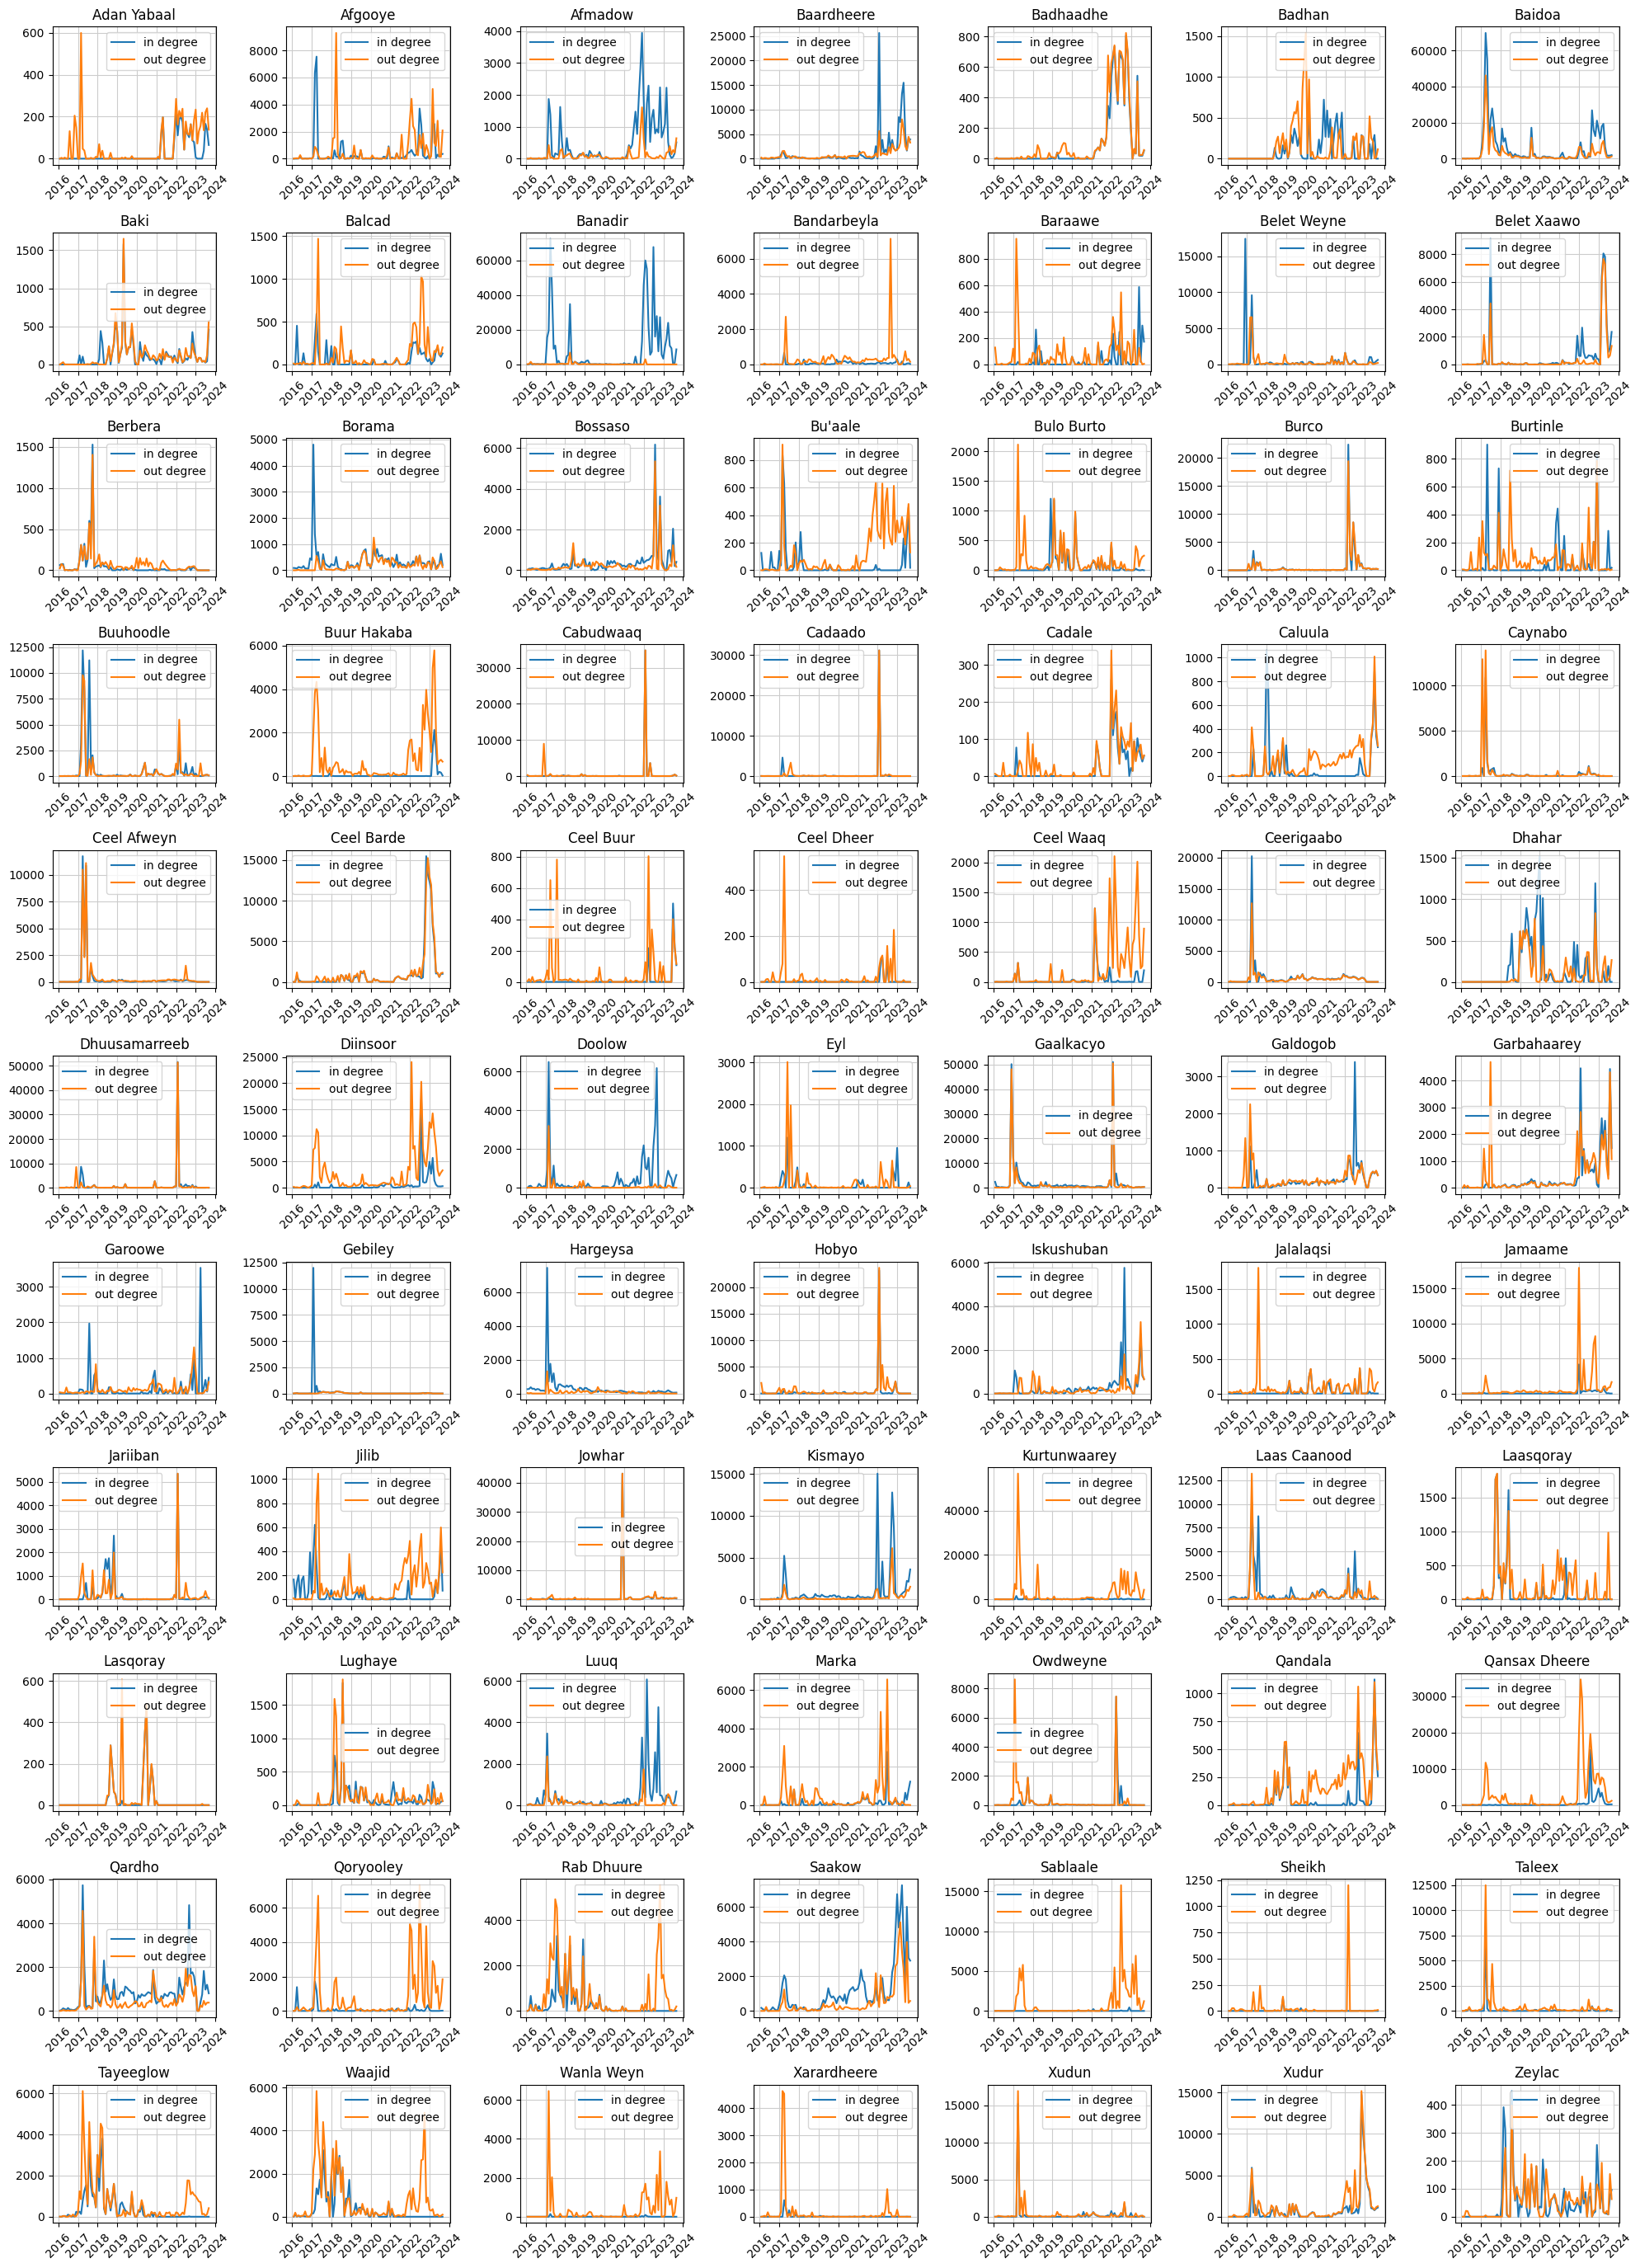

In [ ]:
# create a figure with subplots
fig, axes = plt.subplots(11, 7, figsize=(20, 30))
ax = axes.flatten()
states = df_agg_d['geoid'].unique()
# iterate over the states
for i, state in zip(range(len(states)), states):

    df_agg_state = df_agg_d[df_agg_d['geoid']==state]
    # plot value of stringency index for each date
    ax[i].plot(df_agg_state['date'], df_agg_state['in_degree'], label='in degree')
    ax[i].plot(df_agg_state['date'], df_agg_state['out_degree'], label='out degree')  
    
    ax[i].tick_params(axis='x', rotation=45)

    # add a grid
    ax[i].grid(True, color = '0.8', which='major')
    ax[i].grid(True, color = '0.8', alpha = 0.5, which='minor', linestyle='--')

    ax[i].legend()
    # set state name as title
    ax[i].set_title(state)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

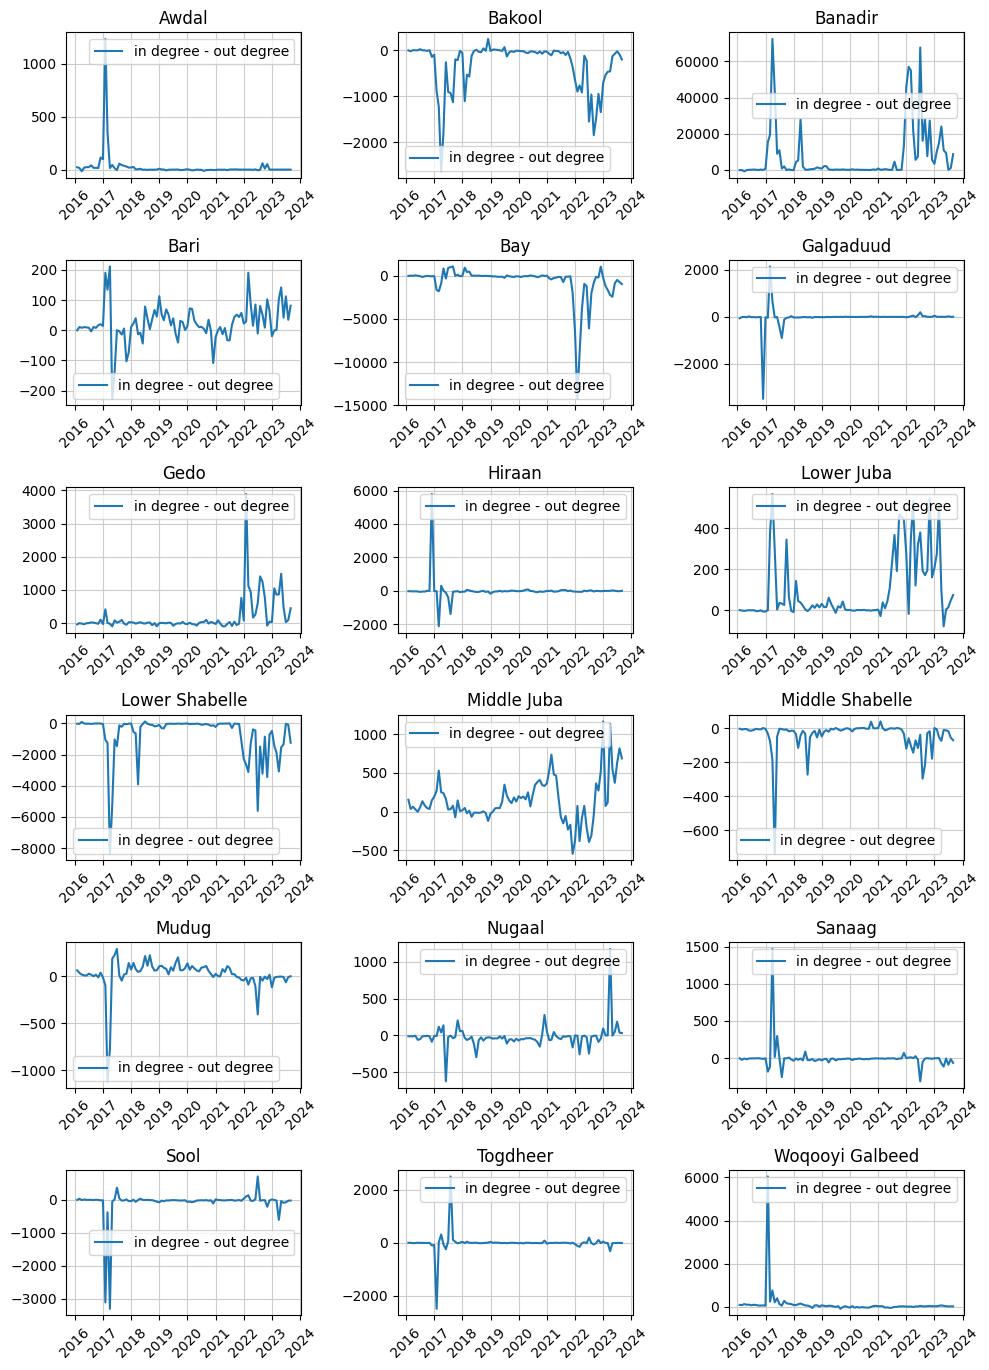

In [ ]:
# create a figure with subplots
fig, axes = plt.subplots(6, 3, figsize=(10, 15))
ax = axes.flatten()
states = df_agg_r['Previous (Departure) Region'].unique()
# iterate over the states
for i, state in zip(range(len(states)), states):

    df_agg_state = df_agg_r[df_agg_r['Previous (Departure) Region']==state]
    # plot value of stringency index for each date
    ax[i].plot(df_agg_state['date'], df_agg_state['in_degree'] - df_agg_state['out_degree'], label='in degree - out degree')  
    ax[i].tick_params(axis='x', rotation=45)
    # add a grid
    ax[i].grid(True, color = '0.8', which='major')
    ax[i].legend()
    # set state name as title
    ax[i].set_title(state)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()